In [1]:
!pip install pygad

You should consider upgrading via the '/Users/royng/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


Modified version of pygad samples. https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad <br>
Model inspired and modified from http://uhurumkate.blogspot.com/2018/06/tiny-model-for-mnist-dataset.html

You're highly encouraged to use a GPU as it's going to spent most resources on predicting and calculating acc. Please also note that pygad library only use CPU paralleal in some cases.

The highest acc was achieved with everything set to False, and with 23 hours of training. 500 cycles and 58% acc

In [2]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import losses, datasets, layers, optimizers, Sequential, metrics
import pygad.kerasga
import numpy
import pygad

# Hyper param

In [3]:
acc_meter = tf.keras.metrics.Accuracy()

#Instead of training a entire dataset, do small batches.
sgd_like = True

#introduce new population when stucked. Often time it'll stuck in local best solution.
introduce_new_pop = True

#increase batch size when stcuked.
dynamic_batch_size = False

In [4]:
#num cycles
num_generations = 1000

#num soltions
num_solution= 10

#the following two param only works if introduce_new_pop = True
#Maxium cycles stuck before introducing new population to the pool.
max_cycles_stucked = 10
#Number of population being replaced with new random population. Must be 0 < x <= num_solution
num_introduce = 10

#The follow two param have effect only when sgd_like = True
#number of cycles you want on a single batch. 
epoch = 20
#number of samples per batch
batch_size = 500

#number batch increase feed into prediction. only have effect if sgd_like = True
#Ex. batch size 300 -> 300 + 300 = 600. Note that some data will be lose during the process
batch_increase = 500

#Typical pygad params
num_parents_mating = int(num_solution * 1)
parent_selection_type = "sss"
mutation_type="adaptive"
mutation_num_genes=(90, 50)
keep_parents = 0

# dataset

In [5]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
#normalize data
X_train = 2*tf.convert_to_tensor(X_train, tf.float32)/255.-1
#[b, 28, 28] -> [b, 28, 28, 1]
X_train = tf.reshape(X_train, (-1, 28,28,1))
X_test = 2*tf.convert_to_tensor(X_test, tf.float32)/255.-1
X_test = tf.reshape(X_test, (-1, 28,28,1))
y_train = tf.convert_to_tensor(y_train, tf.int32)
#[b] -> [b, 10]
y_train = tf.one_hot(y_train, 10)
y_test = tf.convert_to_tensor(y_test, tf.int32)
y_test = tf.one_hot(y_test, 10)

# Model

We want a very small model for the increase in param will increase the cycles GA needs to run </ba>
Model parameter = 2665 with acc ~ 96% on both train/testing sets (trained with triditional method).<br>
EDIT: <br>
 I relized that the model **DO** have impact. For example, when l`ayers.Dense(3, activation='relu')`, you'll have 1.8k param. You might think it'll be easier for the model to converge. Yet, `layers.Dense(10, activation='relu')` is faster. `layers.Dense(20, activation='relu')` is even better with 4.5k param. This indicates we don't need a small model, but a GOOD model (define good).

In [6]:
model = Sequential([
#input layer
layers.Convolution2D(15, (3, 3), activation='relu', input_shape=(28,28,1)),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
layers.AveragePooling2D(2),
#convo layers1
layers.Convolution2D(10,(1,1), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers2
layers.AveragePooling2D(2),
layers.Convolution2D(5,(3,3), activation='relu'),
layers.BatchNormalization(momentum=0.1),
layers.Dropout(0.1),
#convo layers3
layers.Convolution2D(10,(1,1), activation='relu'),
layers.Dropout(0.1),
#fully connected layer1
layers.Dense(32, activation='relu'),
layers.Flatten(),
#output layer
layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 15)        150       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 15)        60        
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 15)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 10)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 10)        40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 10)        0

## FORGET ABOUT CNN, FCNN IS THE WAY TO GO

In [7]:
model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(28,28,1)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                250890    
Total params: 250,954
Trainable params: 250,954
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

#model.fit(X_train, y_train, 
#          batch_size=8, verbose=1,shuffle=True,
#          validation_data=(X_test, y_test))

Network accuracy and error

In [9]:
acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))
acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), tf.argmax(y_train, axis=1))
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

Accuracy on testing set:6.080000102519989%
Error rate on testing set:93.91999989748001%
Accuracy on training set:6.00714273750782%
Error rate on training set:93.99285726249218%


loss

In [10]:
#cce = tf.keras.losses.CategoricalCrossentropy()
#cce(y_train, model.predict(X_train))

In [11]:
#we don't need one-hot to train it's for tf.fit(). To compute tf.argmax each loop is a waste of resources
y_train = tf.argmax(y_train, axis=1)

Perpare batches if we were doing SGD-like method. <br>
Some data are removed if size of dataset / batch_size is not an integer

In [12]:
#A method always modifing X_train_sgd and y_train_sgd
def make_batch(batch_size):
  global X_train_sgd, y_train_sgd
  if len(X_train) % batch_size == 0:
    X_train_sgd = tf.reshape(X_train, [-1, batch_size, 28, 28, 1])
    y_train_sgd = tf.reshape(y_train, [-1, batch_size])
  else:
    #Remove some samples if can't rehape 
    len_remove = len(X_train) % batch_size
    X_train_sgd = tf.reshape(X_train[:-len_remove], [-1, batch_size, 28, 28, 1])
    y_train_sgd = tf.reshape(y_train[:-len_remove], [-1, batch_size])

In [13]:
X_train_sgd = []
y_train_sgd = []
if sgd_like == True:
  make_batch(batch_size)

# Fitness 

In [14]:
#Some helper varibles
i = 0
cycles_stucked = 0
k=0
tmp = 0

#fitness_func uses acc matrix as fitness.
def fitness_func(solution, sol_idx):

    global keras_ga, model, i, cycles_stucked ,X_train, y_train, k
    solution_fitness = 0
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    #if perfer to use loss instead
    #solution_fitness = 1/cce(model.predict(X_train), y_train).numpy()

    if sgd_like == True:
      #update acc_meter
      acc_meter.update_state(tf.argmax(model.predict(X_train_sgd[k]), axis=1), y_train_sgd[k])
      solution_fitness = acc_meter.result().numpy() * 100
      acc_meter.reset_states()
    else:
      acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
      solution_fitness = acc_meter.result().numpy() * 100
      acc_meter.reset_states()
    return solution_fitness

# Crossover function

In [15]:
def crossover_func(parents, offspring_size, ga_instance):
  global cycles_stucked, tmp, parent1
  offspring = []
  idx = 0

  #Standard offspring method from https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#life-cycle-of-pygad
  while len(offspring) != offspring_size[0]:
    parent1 = parents[idx % parents.shape[0], :].copy()
    parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
    random_split_point = numpy.random.choice(range(offspring_size[0]))
    parent1[random_split_point:] = parent2[random_split_point:]
    offspring.append(parent1)
    idx += 1

  offspring = numpy.array(offspring)
  
  if introduce_new_pop and cycles_stucked == max_cycles_stucked:
    #replace the first num_introduce with random variables
    offspring[:num_introduce] = tf.random.truncated_normal(offspring[:num_introduce].shape).numpy()
    print('New gene added')
    #Only want to do this once
    cycles_stucked = 0

  return numpy.array(offspring)

# callback

In [16]:
def callback_generation(ga_instance):
    global i, k, cycles_stucked, tmp
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    #keep track of generation
    i += 1
    if sgd_like == True:
      if i % (1 * epoch) == 0:
        #select random data from reshaped dataset to train
        k = numpy.random.randint(0, len(X_train_sgd)-1)

    if ga_instance.best_solution()[1] == tmp:
      cycles_stucked += 1
      if dynamic_batch_size and cycles_stucked == max_cycles_stucked:
        #increase batch size. Up until only 1 batch with all samples avaliable
        make_batch(min(X_train_sgd.shape[1]+batch_increase, X_train_sgd.shape[0]*X_train_sgd.shape[1]))
        print("Batch size increased -> new shape: ",X_train_sgd.shape)
        #Otherwise introduce_new_pop from cross over will never be True. 
        if not introduce_new_pop:
          #keep track of cycles stucked
          cycles_stucked = 0
    else:
      cycles_stucked = 0
    #update tmp
    tmp = ga_instance.best_solution()[1]

# Run

As observed, rate of accurate increase getting worse and woser. As if a log function. Indeed, it's when GA reached local best. Although over time, GA will get of there (smh given enough time you can brute force AES), but by introducing new genes might* help accerate this process.

In [17]:
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=num_solution)


# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
# Use the pre-existing model weight as init population. 
initial_population = numpy.tile(pygad.kerasga.model_weights_as_vector(model), (num_solution, 1))


ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       keep_parents=keep_parents,
                       mutation_type=mutation_type,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_func,
                       mutation_num_genes=mutation_num_genes,
                       on_generation=callback_generation)

ga_instance.run()

/Users/royng/opt/anaconda3/lib/python3.8/site-packages/pygad/pygad.py:621: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  if not self.suppress_warnings: warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")


Generation = 1
Fitness    = 13.199999928474426
Generation = 2
Fitness    = 14.000000059604645
Generation = 3
Fitness    = 13.199999928474426
Generation = 4
Fitness    = 13.600000739097595
Generation = 5
Fitness    = 13.40000033378601
Generation = 6
Fitness    = 13.600000739097595
Generation = 7
Fitness    = 15.800000727176666
Generation = 8
Fitness    = 18.199999630451202
Generation = 9
Fitness    = 19.40000057220459
Generation = 10
Fitness    = 20.000000298023224
Generation = 11
Fitness    = 21.60000056028366
Generation = 12
Fitness    = 19.79999989271164
Generation = 13
Fitness    = 20.399999618530273
Generation = 14
Fitness    = 21.400000154972076
Generation = 15
Fitness    = 20.800000429153442
Generation = 16
Fitness    = 21.60000056028366
Generation = 17
Fitness    = 20.800000429153442
Generation = 18
Fitness    = 21.99999988079071
Generation = 19
Fitness    = 21.400000154972076
Generation = 20
Fitness    = 20.800000429153442
Generation = 21
Fitness    = 21.199999749660492
Generat

# Stat

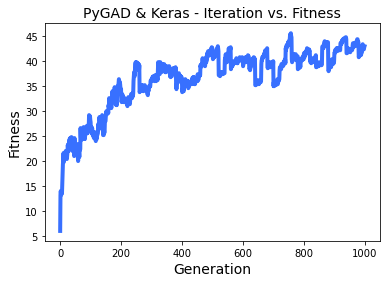

Fitness value of the best solution = 42.80000030994415
Index of the best solution : 0
Accuracy on testing set:41.44999980926514%
Error rate on testing set:58.55000019073486%
Accuracy on training set:41.694286465644836%
Error rate on training set:58.305713534355164%


In [18]:

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)

acc_meter.update_state(tf.argmax(model.predict(X_test), axis=1), tf.argmax(y_test, axis=1))
print("Accuracy on testing set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on testing set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

acc_meter.update_state(tf.argmax(model.predict(X_train), axis=1), y_train)
print("Accuracy on training set:{acc}%".format(acc=acc_meter.result().numpy()*100))
print("Error rate on training set:{err}%".format(err=(1-acc_meter.result().numpy())*100))

The best run I got is 58%, which I got by running the entire training set. It took my 23 hours to finish 500 cycles with i7 10700f and gtx 2060 running in wsl2 on windows 11. It got stuck on 58% for the last 142 cycles with everything set to false. Still playing around with it and we'll see if I can get to to reach 90% without waiting for days.

I am gonna to try something new. Use GA to find the best seed that can actually go up to 90%.